In [32]:
import sys
sys.path.append("../Decision Tree")
# from TreeNode import TreeNode
from DecisionTree import ID3
from utils import predict, calculate_error_rate, preprocess_numerical_columns

In [ ]:
# class TreeNode:
#     def __init__(self, label=None, attributes=None, children=None):
#         self.label = label  # value of the node
#         self.attributes = attributes
#         if children is None:
#             self.children = []
#         else:
#             self.children = children

#     def __str__(self, level=0):
#         prefix = "  " * level
#         result = prefix + f"Attribute: {self.attributes}, Label: {self.label}\n"
#         for child in self.children:
#             result += prefix + f"Child:\n"
#             result += child.__str__(level + 1)
#         return result

#     def add_child(self, child_node):
#         self.children.append(child_node)

#     def predict(self, instance):
#         """
#         instance: a single row from the test dataset
#         return: predicted label
#         """
#         node = self
#         while node.children:
#             attribute_name = node.attributes
#             attribute_value = instance.loc[attribute_name]  # Using .loc to get the value by column name
#             print(f"Checking attribute {attribute_name} with value {attribute_value}")  
#             matched_child = None
#             for child in node.children:
#                 if child.attributes == attribute_value:
#                     matched_child = child
#                     break
            
#             if matched_child:
#                 print(f"Found matching child with attribute {matched_child.attributes}")
#                 node = matched_child
#             else:
#                 print(f"No child matches attribute {attribute_name} with value {attribute_value}")  # Add this
#                 return "default_label_or_most_common_label" 

#         return node.label

In [2]:
import pandas as pd
import numpy as np

# class BaggedTrees:
#     def __init__(self, n_trees=10, max_depth=float('inf')):
#         self.n_trees = n_trees
#         self.trees = []
#         self.max_depth = max_depth

#     def fit(self, data, attributes):
#         for _ in range(self.n_trees):
#             # Bootstrap sampling
#             bootstrap_data = data.sample(n=len(data), replace=True)
#             tree = ID3(bootstrap_data, attributes, self.max_depth)
#             self.trees.append(tree)

#     def predict(self, instance):
#         predictions = [tree.predict(instance) for tree in self.trees]
#         return max(set(predictions), key=predictions.count)

#     def batch_predict(self, df):
#         return [self.predict(row) for _, row in df.iterrows()]


In [33]:
# 创建一个简单的数据集
data_dict = {
    'Weather': ['Sunny', 'Overcast', 'Rainy', 'Sunny', 'Sunny', 'Overcast', 'Rainy', 'Rainy'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'PlayTennis': ['Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes']
}

data = pd.DataFrame(data_dict)
attributes = ['Weather', 'Wind']
tree_root = ID3(data, attributes, float('inf'))
print(tree_root)

Attribute: Weather, Label: None
Child:
  Attribute: Sunny, Label: None
  Child:
    Attribute: Wind, Label: None
    Child:
      Attribute: Weak, Label: Yes
    Child:
      Attribute: Strong, Label: Yes
Child:
  Attribute: Overcast, Label: Yes
Child:
  Attribute: Rainy, Label: Yes



In [34]:
def predict(tree, df_test):
    """
    tree: The tree that has been build from ID3
    df_test: test dataset, dataframe
    return: a list of all prediction labels
    """
    predictions = []
    for index, row in df_test.iterrows():
        node = tree
        while node.children: 
            attribute_name = node.attributes 
            attribute_value = row[attribute_name] 
            matched_child = None
            for child in node.children:
                if child.attributes == attribute_value:  
                    matched_child = child  
                    break
            if matched_child:
                node = matched_child
                for subnode in node.children:
                    node = subnode
            else:
                break
        predictions.append(node.label)  

    return predictions

predictions = predict(tree_root, data)
print(predictions)

['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']


In [35]:
true_labels = data.iloc[:, -1].tolist()
print(true_labels)
error_rate = calculate_error_rate(predictions, true_labels)
print(error_rate)

['Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes']
0.125


In [36]:
test_data_dict = {
    'Weather': ['Sunny', 'Overcast', 'Rainy', 'Sunny'],
    'Wind': ['Strong', 'Weak', 'Weak', 'Strong'],
    'PlayTennis': ['Yes', 'Yes', 'Yes', 'No']  # These are just example labels, you can adjust them if needed
}

test_data = pd.DataFrame(test_data_dict)

In [37]:
import numpy as np

class BaggedTrees:
    def __init__(self, n_trees):
        self.n_trees = n_trees
        self.trees = []

    def fit(self, data, attributes):
        for _ in range(self.n_trees):
            # 1. Sample with replacement from data
            bootstrap_sample = data.sample(n=len(data), replace=True)
            print(bootstrap_sample)
            
            # 2. Train a decision tree on this sample
            tree = ID3(bootstrap_sample, attributes, float('inf'))
            # print("tree: ",tree)
            self.trees.append(tree)
            
    def predict(self, dataset):
        all_predictions = []

        # For each instance in the dataset
        for _, instance in dataset.iterrows():
            # Predict with each tree and vote
            predictions = [tree.predict(instance) for tree in self.trees]
            # Append the majority vote to all_predictions
            all_predictions.append(max(set(predictions), key=predictions.count))

        return all_predictions
    # def predict(self, instance):
    #     # Predict with each tree and vote
    #     predictions = [tree.predict(instance) for tree in self.trees]
    #     return max(set(predictions), key=predictions.count)

# Using it:
# bagged_model = BaggedTrees(n_trees=50)
# bagged_model.fit(df, attributes)

In [38]:
print(data)

    Weather    Wind PlayTennis
0     Sunny    Weak        Yes
1  Overcast  Strong        Yes
2     Rainy    Weak        Yes
3     Sunny    Weak         No
4     Sunny  Strong        Yes
5  Overcast  Strong        Yes
6     Rainy    Weak        Yes
7     Rainy  Strong        Yes


In [39]:
class BaggedTrees:
    def __init__(self, n_trees):
        self.n_trees = n_trees
        self.trees = []

    def fit(self, data, attributes):
        for _ in range(self.n_trees):
            # 1. Sample with replacement from data
            bootstrap_sample = data.sample(n=len(data), replace=True)
            
            # 2. Train a decision tree on this sample
            tree = ID3(bootstrap_sample, attributes, float('inf'))
            self.trees.append(tree)

    def predict_tree(self, tree, instance):
        node = tree
        while node.children: 
            attribute_name = node.attributes 
            attribute_value = instance[attribute_name]
            matched_child = None
            for child in node.children:
                if child.attributes == attribute_value:  
                    matched_child = child  
                    break
            if matched_child:
                node = matched_child
                for subnode in node.children:
                    node = subnode
            else:
                break
        return node.label

    def predict(self, dataset):
        all_predictions = []

        # For each instance in the dataset
        for _, instance in dataset.iterrows():
            # Predict with each tree and vote
            predictions = [self.predict_tree(tree, instance) for tree in self.trees]
            # Append the majority vote to all_predictions
            all_predictions.append(max(set(predictions), key=predictions.count))

        return all_predictions


In [40]:
bagged_model = BaggedTrees(n_trees=1)
# attributes = ['Weather', 'Wind']
bagged_model.fit(data, attributes)

In [41]:
#training error
predictions = bagged_model.predict(data)
print(predictions)
true_labels = data.iloc[:, -1].tolist()
print(true_labels)
error_rate = calculate_error_rate(predictions, true_labels)
print(f"Training Error Rate {error_rate:.3f}")

['No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes']
['Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes']
Training Error Rate 0.250


In [42]:
# test error
predicted_labels = bagged_model.predict(test_data)
true_labels = test_data.iloc[:, -1].tolist()
test_error_rate = calculate_error_rate(predicted_labels, true_labels)
print("test_error_rate: ", test_error_rate)

test_error_rate:  0.25


In [43]:
# Test for real data set
def preprocess_data(df):
    # Convert continuous attributes to binary
    for column in ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']:
        median = df[column].median()
        df[column] = df[column].apply(lambda x: 1 if x > median else 0)
    
    # Note: For columns with "unknown", we'll leave them as is. Pandas will treat them as a separate category.
    
    return df

# Load the training and test data
test_file_path = "Data/bank-4/test.csv"
train_file_path = "Data/bank-4/train.csv"
column_names = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df_bank_train = pd.read_csv(train_file_path, names=column_names)
df_bank_test = pd.read_csv(test_file_path, names=column_names)
bank_attributes = df_bank_train.columns.tolist()[:-1]

# Apply preprocessing to train and test datasets
train_data = preprocess_data(df_bank_train)
test_data = preprocess_data(df_bank_test)
attributes = bank_attributes


In [44]:
for n in range(1, 11):  # Looping n from 1 to 10
    bagged_model = BaggedTrees(n_trees=n)
    bagged_model.fit(train_data, attributes)

    # Training error
    predictions = bagged_model.predict(train_data)
    true_labels_train = train_data.iloc[:, -1].tolist()
    error_rate_train = calculate_error_rate(predictions, true_labels_train)
    print("Bagged Trees with n= {} Training Error Rate {}".format(n, error_rate_train))

    # Testing error
    predictions = bagged_model.predict(test_data)
    true_labels_test = test_data.iloc[:, -1].tolist()
    error_rate_test = calculate_error_rate(predictions, true_labels_test)
    print("Bagged Trees with n= {} Testing Error Rate {}".format(n, error_rate_test))
    print("------------------------------------------------")


Bagged Trees with n= 1 Training Error Rate 0.08
Bagged Trees with n= 1 Testing Error Rate 0.1912
------------------------------------------------
Bagged Trees with n= 2 Training Error Rate 0.066
Bagged Trees with n= 2 Testing Error Rate 0.157
------------------------------------------------
Bagged Trees with n= 3 Training Error Rate 0.0476
Bagged Trees with n= 3 Testing Error Rate 0.1722
------------------------------------------------
Bagged Trees with n= 4 Training Error Rate 0.0464
Bagged Trees with n= 4 Testing Error Rate 0.1488
------------------------------------------------
Bagged Trees with n= 5 Training Error Rate 0.0368
Bagged Trees with n= 5 Testing Error Rate 0.1674
------------------------------------------------
Bagged Trees with n= 6 Training Error Rate 0.036
Bagged Trees with n= 6 Testing Error Rate 0.1546
------------------------------------------------
Bagged Trees with n= 7 Training Error Rate 0.0282
Bagged Trees with n= 7 Testing Error Rate 0.1606
------------------

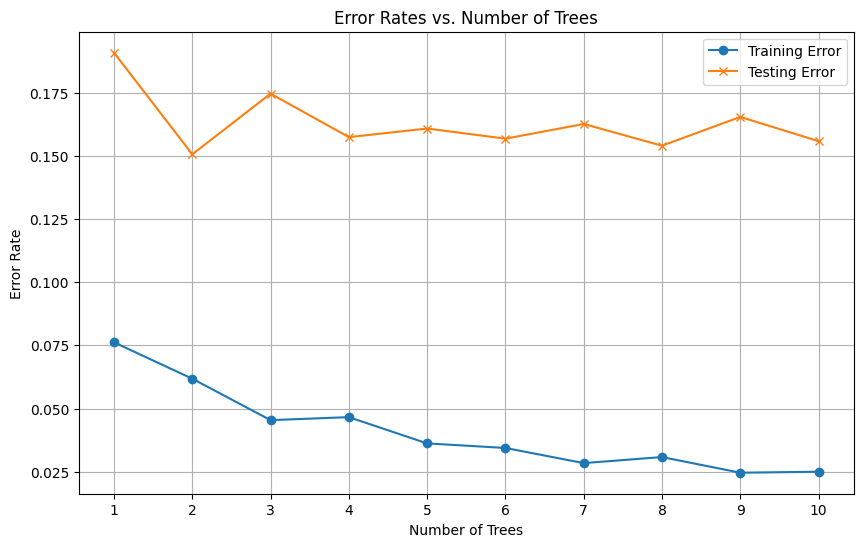

In [48]:
import matplotlib.pyplot as plt

training_errors = []
testing_errors = []

for n in range(1, 11):  # Looping n from 1 to 500
    bagged_model = BaggedTrees(n_trees=n)
    bagged_model.fit(train_data, attributes)

    # Training error
    predictions = bagged_model.predict(train_data)
    true_labels_train = train_data.iloc[:, -1].tolist()
    error_rate_train = calculate_error_rate(predictions, true_labels_train)
    training_errors.append(error_rate_train)

    # Testing error
    predictions = bagged_model.predict(test_data)
    true_labels_test = test_data.iloc[:, -1].tolist()
    error_rate_test = calculate_error_rate(predictions, true_labels_test)
    testing_errors.append(error_rate_test)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), training_errors, label='Training Error', marker='o')
plt.plot(range(1, 11), testing_errors, label='Testing Error', marker='x')
plt.xlabel('Number of Trees')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

In [51]:
import matplotlib.pyplot as plt

training_errors = []
testing_errors = []

for n in range(1, 500):  # Looping n from 1 to 500
    bagged_model = BaggedTrees(n_trees=n)
    bagged_model.fit(train_data, attributes)

    # Training error
    predictions = bagged_model.predict(train_data)
    true_labels_train = train_data.iloc[:, -1].tolist()
    error_rate_train = calculate_error_rate(predictions, true_labels_train)
    training_errors.append(error_rate_train)

    # Testing error
    predictions = bagged_model.predict(test_data)
    true_labels_test = test_data.iloc[:, -1].tolist()
    error_rate_test = calculate_error_rate(predictions, true_labels_test)
    testing_errors.append(error_rate_test)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), training_errors, label='Training Error', marker='o')
plt.plot(range(1, 20), testing_errors, label='Testing Error', marker='x')
plt.xlabel('Number of Trees')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 20))
plt.show()


KeyboardInterrupt: 

In [52]:
def calculate_bias_variance(bagged_model, test_data, true_labels):
    """
    Calculate bias and variance for the bagged model.

    bagged_model: The trained BaggedTrees model.
    test_data: The test dataset.
    true_labels: The true labels of the test dataset.

    Returns:
        bias: Calculated bias
        variance: Calculated variance
    """
    
    # Initialize bias and variance to zero
    bias = 0.0
    variance = 0.0
    
    # For each label in the test data
    for idx, true_label in enumerate(true_labels):
        avg_prediction = 0
        tree_predictions = []
        
        # Predict with each tree
        for tree in bagged_model.trees:
            single_prediction = predict(tree, test_data.iloc[[idx]])
            tree_predictions.append(single_prediction[0])  # [0] to get the single prediction
        
        # Calculate average prediction for this instance
        avg_prediction = tree_predictions.count('yes') / len(tree_predictions)
        
        # Convert the true label to binary format (-1 or 1)
        y = 1 if true_label == 'yes' else -1
        
        # Update bias and variance
        bias += np.power(y - avg_prediction, 2)
        variance += np.var(np.where(np.array(tree_predictions) == 'yes', 1, -1))
    
    # Calculate average bias and variance
    avg_bias = bias / len(test_data)
    avg_variance = variance / len(test_data)
    
    return avg_bias, avg_variance


In [53]:
# Assume your BaggedTrees model is trained and stored in the variable "bagged_model"
true_labels = test_data.iloc[:, -1].tolist()
bias, variance = calculate_bias_variance(bagged_model, test_data, true_labels)
print("Bias:", bias)
print("Variance:", variance)


Bias: 1.1274
Variance: 0.1636


Average Bias: 0.38436800000000004
Average Variance: 0.297072


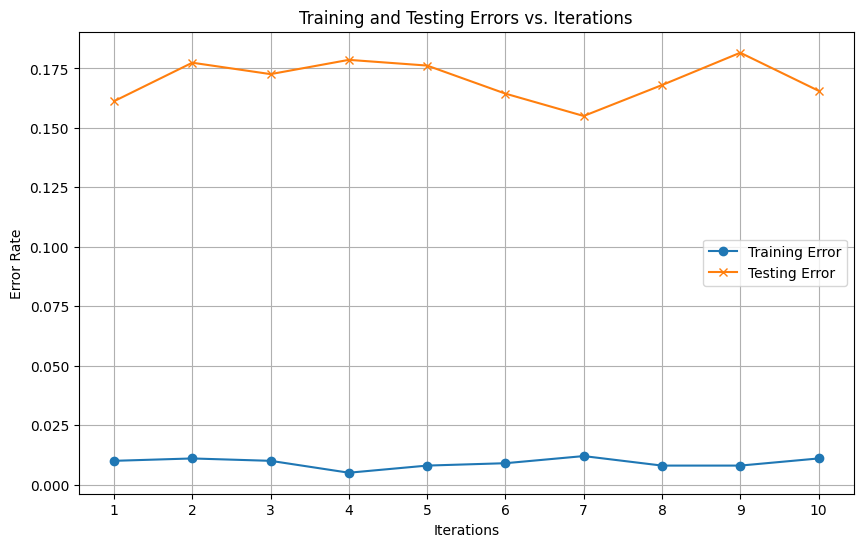

In [56]:
import numpy as np

def sample_data(train_data, sample_size=1000):
    """Sample data uniformly without replacement."""
    return train_data.sample(n=sample_size, replace=False)

# Initialize the variables
n_iterations = 10
n_trees = 20
bagged_predictors = []
single_trees = []

training_errors = []
testing_errors = []

# REPEAT for 100 times
for _ in range(n_iterations):
    # STEP 1: Sample 1000 examples uniformly without replacement
    sampled_data = sample_data(train_data)
    
    # STEP 2: Run bagged trees learning algorithm based on the 1000 training examples and learn 500 trees
    bagged_model = BaggedTrees(n_trees=n_trees)
    bagged_model.fit(sampled_data, attributes)
    
    # Calculate training error for this iteration
    train_predictions = bagged_model.predict(sampled_data)
    true_labels_train = sampled_data.iloc[:, -1].tolist()
    error_rate_train = calculate_error_rate(train_predictions, true_labels_train)
    training_errors.append(error_rate_train)
    
    # Calculate testing error for this iteration
    test_predictions = bagged_model.predict(test_data)
    true_labels_test = test_data.iloc[:, -1].tolist()
    error_rate_test = calculate_error_rate(test_predictions, true_labels_test)
    testing_errors.append(error_rate_test)

    # Store the model and the first tree
    bagged_predictors.append(bagged_model)
    single_trees.append(bagged_model.trees[0])

# Now, you have 100 bagged predictors and 100 single trees
# Let's compute bias and variance for a test example
all_single_tree_predictions = []

for test_example in test_data.iterrows():
    single_tree_predictions = [predict(tree, pd.DataFrame([test_example[1]])) for tree in single_trees]
    all_single_tree_predictions.append(single_tree_predictions)

# Convert the predictions to a binary format for easier calculations
binary_predictions = [[1 if pred[0] == 'yes' else -1 for pred in predictions] for predictions in all_single_tree_predictions]
true_labels_binary = [1 if label == 'yes' else -1 for label in test_data.iloc[:, -1].tolist()]

biases = []
variances = []

for i, test_example_predictions in enumerate(binary_predictions):
    # Calculate bias for this test example
    avg_prediction = np.mean(test_example_predictions)
    bias = (true_labels_binary[i] - avg_prediction) ** 2
    biases.append(bias)
    
    # Calculate variance for this test example
    variance = np.var(test_example_predictions)
    variances.append(variance)

# Compute the average bias and variance
avg_bias = np.mean(biases)
avg_variance = np.mean(variances)

print("Average Bias:", avg_bias)
print("Average Variance:", avg_variance)

# Plot training and testing errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), training_errors, label='Training Error', marker='o')
plt.plot(range(1, n_iterations + 1), testing_errors, label='Testing Error', marker='x')
plt.xlabel('Iterations')
plt.ylabel('Error Rate')
plt.title('Training and Testing Errors vs. Iterations')
plt.legend()
plt.grid(True)
plt.xticks(range(1, n_iterations + 1))
plt.show()